<img src="../logo_skmob.png" width=250 align="left" />

# Preprocessing

- [Preprocessing GPS data](#Preprocessing-GPS-data)
- [Preprocessing LBSN (social media) data](#Preprocessing-LBSN-&#40;social-media&#41;-data)

In [1]:
import skmob
from skmob.utils import constants
from skmob.utils import utils

from geopy.distance import distance
import pandas as pd
import numpy as np

# Preprocessing GPS data

## Load data from file

Subset of data from the Geolife project, available [here](https://www.microsoft.com/en-us/download/details.aspx?id=52367).

In [2]:
# %%time
tdf = skmob.TrajDataFrame.from_file('./data/geolife_sample.txt.gz')
tdf[:4]

,lat,lng,datetime,uid
0,39.984094,116.319236,2008-10-23 05:53:05,1
1,39.984198,116.319322,2008-10-23 05:53:06,1
2,39.984224,116.319402,2008-10-23 05:53:11,1
3,39.984211,116.319389,2008-10-23 05:53:16,1


In [3]:
tdf.dtypes

lat                float64
lng                float64
datetime    datetime64[ns]
uid                  int64
dtype: object

In [4]:
tdf.crs

{'init': 'epsg:4326'}

In [5]:
tdf.parameters

{'from_file': './data/geolife_sample.txt.gz'}

#### Convert `datetime` column from original timezone `'GMT'` to local timezione `'Asia/Shanghai'`

In [6]:
tdf.timezone_conversion(from_timezone='GMT', to_timezone='Asia/Shanghai')
tdf[:4]

,lat,lng,uid,datetime
0,39.984094,116.319236,1,2008-10-23 13:53:05
1,39.984198,116.319322,1,2008-10-23 13:53:06
2,39.984224,116.319402,1,2008-10-23 13:53:11
3,39.984211,116.319389,1,2008-10-23 13:53:16


#### Visualise the raw trajectories on a map

Plot the trajectories of `max_users=2` users. 

To save memory, each trajectory is downsampled so that at most `max_points=2000` points are plotted.

In [7]:
map_f = tdf.plot_trajectory(max_users=2, max_points=2000) #, tiles='Stamen Toner') # try this for a b/w map
map_f
# map_f.save('./raw_trajectory.html') # Save plot to html file

Plot the first 10k points of the user 1's trajectory

In [8]:
tdf[tdf['uid'] == 1][:10000].plot_trajectory(weight=3, max_points=None)

## Filtering

Filter out all points with speed higher than `max_speed` km/h from the previous point.

In [9]:
from skmob.preprocessing import filtering

In [10]:
tdf.parameters

{'from_file': './data/geolife_sample.txt.gz'}

In [11]:
ftdf = filtering.filter(tdf, max_speed_kmh=500.)

In [12]:
ftdf.parameters

{'from_file': './data/geolife_sample.txt.gz',
 'filter': {'function': 'filter',
  'max_speed_kmh': 500.0,
  'include_loops': False,
  'speed_kmh': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25}}

In [13]:
ftdf[:4]

,lat,lng,uid,datetime
0,39.984094,116.319236,1,2008-10-23 13:53:05
1,39.984198,116.319322,1,2008-10-23 13:53:06
2,39.984224,116.319402,1,2008-10-23 13:53:11
3,39.984211,116.319389,1,2008-10-23 13:53:16


Very few points have been filtered.

In [14]:
print('Points of the raw trajectory: %s'%len(tdf))
print('Points of the filtered trajectory: %s'%len(ftdf))

Points of the raw trajectory: 217653
Points of the filtered trajectory: 217599


#### Inspect the filtered points

In [15]:
merged = tdf.merge(ftdf, indicator=True, how='outer')
diff_df = merged[merged['_merge'] == 'left_only']

In [16]:
diff_df[:10]

,lat,lng,uid,datetime,_merge
149,39.977648,116.326925,1,2008-10-23 18:33:00,left_only
17792,40.013398,116.306490,1,2008-10-27 20:27:55,left_only
23212,39.975403,116.312814,1,2008-10-31 14:15:21,left_only
23213,39.975342,116.312961,1,2008-10-31 14:15:23,left_only
24509,40.070867,116.301276,1,2008-11-01 09:06:36,left_only
24510,40.070832,116.301441,1,2008-11-01 09:06:37,left_only
25373,40.062216,116.294486,1,2008-11-01 12:17:41,left_only
25374,40.061976,116.294452,1,2008-11-01 12:17:42,left_only
25375,40.061711,116.294270,1,2008-11-01 12:17:43,left_only
25376,40.061615,116.294441,1,2008-11-01 12:17:44,left_only


Extract the filtered points between indexes `25372` and `25377`.

In [17]:
imin = 25373 - 1
imax = 25376 + 1
dt_start = tdf.iloc[imin]['datetime']
dt_end = tdf.iloc[imax]['datetime']

filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == 1)]

unfiltered_tdf = tdf[(tdf['datetime'] >= dt_start) \
                  & (tdf['datetime'] <= dt_end) \
                  & (tdf['uid'] == 1)]

In [18]:
filtered_tdf

,lat,lng,uid,datetime
25366,40.064046,116.301866,1,2008-11-01 12:17:40
25367,40.061521,116.294584,1,2008-11-01 12:17:45


In [19]:
unfiltered_tdf

,lat,lng,uid,datetime
25372,40.064046,116.301866,1,2008-11-01 12:17:40
25373,40.062216,116.294486,1,2008-11-01 12:17:41
25374,40.061976,116.294452,1,2008-11-01 12:17:42
25375,40.061711,116.294270,1,2008-11-01 12:17:43
25376,40.061615,116.294441,1,2008-11-01 12:17:44
25377,40.061521,116.294584,1,2008-11-01 12:17:45


Compute the speeds between consecutive points on the unfiltered trajectory

In [20]:
la_lo_dt = unfiltered_tdf[['lat', 'lng', 'datetime']].values

In [21]:
# average speed (km/h) between the last point not filtered and the following points

i0 = 0 
la0, lo0, dt0 = la_lo_dt[i0]
pd.DataFrame(
    [[dt0, dt , distance((la,lo), (la0, lo0)).km / ((dt - dt0).seconds / 3600) ] \
     for i,(la,lo,dt) in enumerate(la_lo_dt[i0+1:])], \
             columns=['time 0', 'time 1', 'speed (km/h)'])

,time 0,time 1,speed (km/h)
0,2008-11-01 12:17:40,2008-11-01 12:17:41,2381.767297
1,2008-11-01 12:17:40,2008-11-01 12:17:42,1211.387556
2,2008-11-01 12:17:40,2008-11-01 12:17:43,837.594263
3,2008-11-01 12:17:40,2008-11-01 12:17:44,619.722216
4,2008-11-01 12:17:40,2008-11-01 12:17:45,490.752215


All points with speed higher than `max_speed=500.` km/h have been filtered.

##### Visualise the filtered points

In [22]:
# Cut a buffer of 10 points arounfd the filtered part
user_id = 1

imin = 25373 - 10
imax = 25376 + 10
dt_start = tdf.iloc[imin]['datetime']
dt_end = tdf.iloc[imax]['datetime']

filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == user_id)]

unfiltered_tdf = tdf[(tdf['datetime'] >= dt_start) \
                  & (tdf['datetime'] <= dt_end) \
                  & (tdf['uid'] == user_id)]

In [23]:
map_f = unfiltered_tdf.plot_trajectory(zoom=15, weight=10, opacity=0.5) #, tiles='Stamen Toner')
map_f = filtered_tdf.plot_trajectory(map_f=map_f, max_users=1)

map_f

- The thick line is the unfiltered trajectory (`unfiltered_tdf`)
- The thin line is the filtered trajectory (`filtered_tdf`)

## Compression

Reduce the number of points of the trajectory, preserving the structure.

Merge together all points that are closer than `spatial_radius_km=0.2` kilometers from each other.

In [24]:
from skmob.preprocessing import compression

In [25]:
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
ctdf[:4]

,lat,lng,uid,datetime
0,39.984302,116.320730,1,2008-10-23 13:53:05
1,39.982115,116.321225,1,2008-10-23 13:56:06
2,39.979737,116.321564,1,2008-10-23 13:57:03
3,39.979672,116.323778,1,2008-10-23 13:59:05


In [26]:
ctdf.parameters

{'from_file': './data/geolife_sample.txt.gz',
 'filter': {'function': 'filter',
  'max_speed_kmh': 500.0,
  'include_loops': False,
  'speed_kmh': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius_km': 0.2}}

The compressed trajectory has only a small fraction of the points of the filtered trajectory.

In [27]:
print('Points of the filtered trajectory: %s'%len(ftdf))
print('Points of the compressed trajectory: %s'%len(ctdf))

Points of the filtered trajectory: 217599
Points of the compressed trajectory: 6278


#### Visualise the filtered and compressed trajectories

Show the first 10000 points of the trajectory of the first user.

In [41]:
end_time = ftdf.iloc[10000]['datetime']

map_f = ftdf[ftdf['datetime'] < end_time].plot_trajectory(max_users=1, weight=5, \
                                            opacity=0.5, start_end_markers=False)

ctdf[ctdf['datetime'] < end_time].plot_trajectory(max_users=1, map_f=map_f, \
                                                  start_end_markers=False)


- The thick line is the filtered trajectory (`ftdf`)
- The thin line is the compressed trajectory (`ctdf`)

## Stop detection

Identify locations where the user spent at least `minutes_for_a_stop` minutes within a distance `spatial_radius_km` $\times$ `stop_radius_factor`, from a given point. 

A new column `leaving_datetime` is added, indicating the time when the user departs from the stop.

In [42]:
from skmob.preprocessing import detection

In [43]:
stdf = detection.stops(ctdf, stop_radius_factor=0.5, \
            minutes_for_a_stop=20.0, spatial_radius_km=0.2, 
                       leaving_time=True)
stdf[:4]

,lat,lng,uid,datetime,leaving_datetime
0,39.978253,116.327275,1,2008-10-23 14:01:05,2008-10-23 18:32:53
1,40.013819,116.306532,1,2008-10-23 19:10:09,2008-10-24 07:46:02
2,39.978987,116.326686,1,2008-10-24 08:10:39,2008-10-24 09:48:57
3,39.981316,116.310181,1,2008-10-24 09:56:47,2008-10-24 11:21:09


In [44]:
stdf.parameters

{'from_file': './data/geolife_sample.txt.gz',
 'filter': {'function': 'filter',
  'max_speed_kmh': 500.0,
  'include_loops': False,
  'speed_kmh': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius_km': 0.2},
 'detect': {'function': 'stops',
  'stop_radius_factor': 0.5,
  'minutes_for_a_stop': 20.0,
  'spatial_radius_km': 0.2,
  'leaving_time': True,
  'no_data_for_minutes': 1000000000000.0,
  'min_speed_kmh': None}}

In [45]:
stdf.dtypes

lat                        float64
lng                        float64
uid                          int64
datetime            datetime64[ns]
leaving_datetime    datetime64[ns]
dtype: object

#### Visualise the compressed trajectory and the stops

Click on the stop markers to see a pop up with: 
- User ID
- Coordinates of the stop (click to see the location on Google maps)
- Arrival time
- Departure time

In [48]:
map_f = ctdf.plot_trajectory(max_points=1000, hex_color=-1, start_end_markers=False)
stdf.plot_stops(map_f=map_f, hex_color=-1)

## Clustering stops

Stops are clustered by spatial proximity using DBSCAN.

The new column `cluster` is added to the Stops TrajectoryDataFrame, where the value correspond to the cluster ID each stop belong to. 

Clusters IDs are integers (0, 1, ...): 0 is the most visited cluster, 1 is the second most visited, ...

In [49]:
from skmob.preprocessing import clustering

In [50]:
cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)
cstdf[:4]

,lat,lng,uid,datetime,leaving_datetime,cluster
0,39.978253,116.327275,1,2008-10-23 14:01:05,2008-10-23 18:32:53,0
1,40.013819,116.306532,1,2008-10-23 19:10:09,2008-10-24 07:46:02,1
2,39.978987,116.326686,1,2008-10-24 08:10:39,2008-10-24 09:48:57,0
3,39.981316,116.310181,1,2008-10-24 09:56:47,2008-10-24 11:21:09,7


In [51]:
cstdf.parameters

{'from_file': './data/geolife_sample.txt.gz',
 'filter': {'function': 'filter',
  'max_speed_kmh': 500.0,
  'include_loops': False,
  'speed_kmh': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius_km': 0.2},
 'detect': {'function': 'stops',
  'stop_radius_factor': 0.5,
  'minutes_for_a_stop': 20.0,
  'spatial_radius_km': 0.2,
  'leaving_time': True,
  'no_data_for_minutes': 1000000000000.0,
  'min_speed_kmh': None},
 'cluster': {'function': 'cluster',
  'cluster_radius_km': 0.1,
  'min_samples': 1}}

#### Visualise the compressed trajectory and stops: stops in the same clusters have the same color.

Click on the stop markers to see a pop up with: 
- User ID
- Cluster ID
- Coordinates of the stop (click to see the location on Google maps)
- Arrival time
- Departure time

In [53]:
map_f = ctdf[ctdf['uid'] == 1].plot_trajectory(max_points=None, \
                                               hex_color='#000000', start_end_markers=False)
cstdf[stdf['uid'] == 1].plot_stops(map_f=map_f)

#### Visualise a user's diary

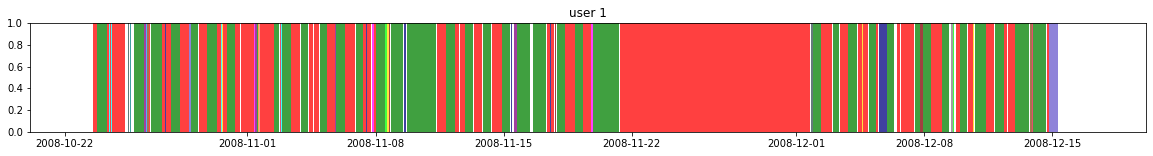

In [55]:
user = 1
start_datetime = pd.to_datetime('2008-10-20 030000')
end_datetime = pd.to_datetime('2008-12-20 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

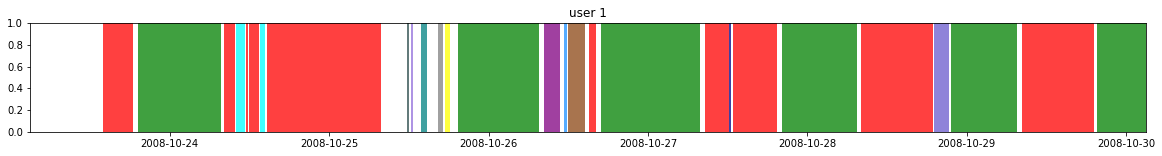

In [56]:
user = 1
start_datetime = pd.to_datetime('2008-10-23 030000')
end_datetime = pd.to_datetime('2008-10-30 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

## Split trajectory into daily trajectories

In [57]:
import skmob
from skmob.utils import utils
from skmob.preprocessing import filtering, compression, detection, clustering

In [58]:
# Re-run all the preprocessing operations in one cell

tdf = skmob.TrajDataFrame.from_file('./data/geolife_sample.txt.gz', sep=',') 
ftdf = filtering.filter(tdf, max_speed_kmh=500.)
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
stdf = detection.stops(ctdf, stop_radius_factor=0.5, \
            minutes_for_a_stop=20.0, spatial_radius_km=0.2, leaving_time=True)
cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)

In [59]:
groups = utils.group_df_by_time(cstdf[cstdf['uid'] == 1], 
                        offset_value=3, offset_unit='hours', add_starting_location=True)
groups[:3]

[         lat         lng            datetime  uid    leaving_datetime  cluster
 0  39.978253  116.327275 2008-10-23 06:01:05    1 2008-10-23 10:32:53        0
 1  40.013819  116.306532 2008-10-23 11:10:09    1 2008-10-23 23:46:02        1
 2  39.978987  116.326686 2008-10-24 00:10:39    1 2008-10-24 01:48:57        0
 3  39.981316  116.310181 2008-10-24 01:56:47    1 2008-10-24 03:21:09        7,
          lat         lng            datetime  uid    leaving_datetime  cluster
 0  39.981316  116.310181 2008-10-24 01:56:47    1 2008-10-24 03:21:09        7
 1  39.979580  116.313649 2008-10-24 03:26:35    1 2008-10-24 03:50:36       42
 2  39.978696  116.326220 2008-10-24 03:55:33    1 2008-10-24 05:30:40        0
 3  39.981538  116.310790 2008-10-24 05:36:46    1 2008-10-24 06:23:07        7
 4  39.978161  116.327242 2008-10-24 06:34:30    1 2008-10-24 23:44:05        0,
          lat         lng            datetime  uid    leaving_datetime  cluster
 0  39.978161  116.327242 2008-10-24 0

#### Visualise the diaries of each sub-trajectory

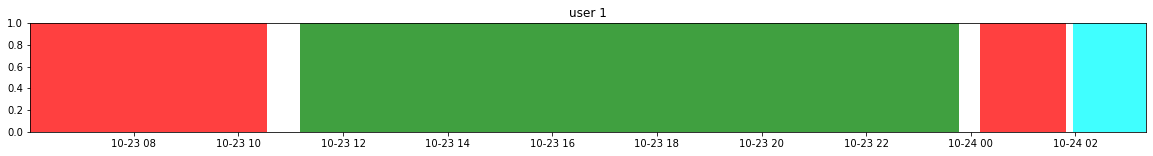

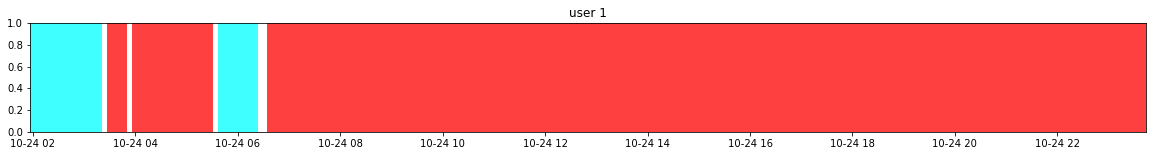

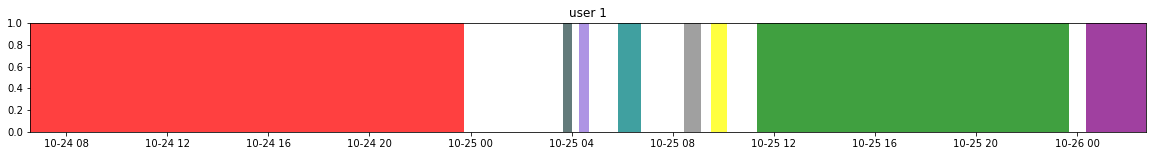

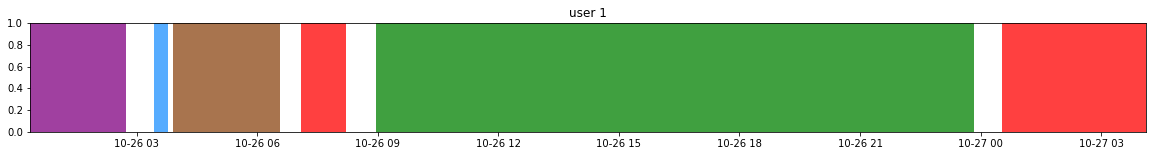

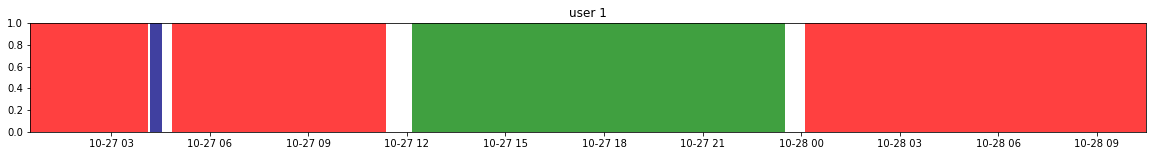

In [60]:
for tdf in groups[:5]:
    user = tdf['uid'].iloc[0]
    ax = tdf.plot_diary(user)

## Routing

Using OSMnx and networkx (taken from <https://medium.com/@bobhaffner/osmnx-intro-and-routing-1fd744ba23d8>).

In [61]:
import osmnx as ox
import folium

In [62]:
start_i = 0
dt_start = cstdf.iloc[start_i]['leaving_datetime']
dt_end = cstdf.iloc[start_i + 1]['datetime']
user_id = cstdf.iloc[start_i]['uid']

dt_start, dt_end

(Timestamp('2008-10-23 10:32:53'), Timestamp('2008-10-23 11:10:09'))

In [64]:
tdf1 = ftdf[(ftdf['datetime'] >= dt_start) & \
            (ftdf['datetime'] <= dt_end) & \
            (ftdf['uid'] == user_id)]
tdf1.plot_trajectory()

Raw GPS data

In [65]:
G, shortest_route = tdf1.route()

In [67]:
m = ox.plot_route_folium(G, shortest_route, route_color='green')
tdf1.plot_trajectory(map_f=m)

Shortest path between origin and destination (green) and raw GPS data

# Preprocessing LBSN (social media) data

## Load data 
Checkin data from Brightkite, available [here](https://snap.stanford.edu/data/loc-Brightkite.html).

In [ ]:
# only load the first 10000 rows

url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=10000, 
                 names=['user', 'check-in_time', "latitude", "longitude", "location id"]
                )
print(len(df))
df[:4]

In [49]:
df.dtypes

user               int64
check-in_time     object
latitude         float64
longitude        float64
location id       object
dtype: object

Create the `TrajectoryDataFrame`

In [51]:
tdf = skmob.TrajDataFrame(df, latitude='latitude', longitude='longitude', \
                          datetime='check-in_time', user_id='user')
tdf[:4]

,uid,datetime,lat,lng,location id
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc


Drop the column `location id`

In [52]:
tdf.drop(columns=['location id'], inplace=True)
tdf[:4]

,uid,datetime,lat,lng
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073
3,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337


Sort rows by user ID and time

In [53]:
tdf.dtypes

uid                       int64
datetime    datetime64[ns, UTC]
lat                     float64
lng                     float64
dtype: object

Delocalize the `datetime` column (remove timezone info)

In [54]:
tdf['datetime'] = tdf['datetime'].dt.tz_localize(None)
tdf[:4]

,uid,datetime,lat,lng
0,0,2010-10-16 06:02:04,39.891383,-105.070814
1,0,2010-10-16 03:48:54,39.891077,-105.068532
2,0,2010-10-14 18:25:51,39.750469,-104.999073
3,0,2010-10-14 00:21:47,39.752713,-104.996337


In [55]:
tdf.dtypes

uid                  int64
datetime    datetime64[ns]
lat                float64
lng                float64
dtype: object

## Filtering

Filter out all points with speed higher than `max_speed` km/h from the previous point.

In [56]:
from skmob.preprocessing import filtering

In [57]:
ftdf = filtering.filter(tdf, max_speed=500.)
ftdf[:4]

,uid,datetime,lat,lng
0,0,2009-05-25 20:56:10,37.774929,-122.419415
1,0,2009-05-25 21:35:28,37.600747,-122.382376
2,0,2009-05-25 21:37:44,37.600747,-122.382376
3,0,2009-05-25 21:42:47,37.600747,-122.382376


In [58]:
print('Points of the raw trajectory: %s.'%len(tdf))
print('Points of the filtered trajectory: %s.'%len(ftdf))

Points of the raw trajectory: 10000.
Points of the filtered trajectory: 9727.


## Compression

Reduce the number of points of the trajectory, preserving the structure.

In [59]:
from skmob.preprocessing import compression

Merge together all points that are closer than `spatial_radius=0.2` kilometers from each other.

In [60]:
# %%time

ctdf = compression.compress(ftdf, spatial_radius=0.2)
ctdf[:4]

,uid,datetime,lat,lng
0,0,2009-05-25 20:56:10,37.774929,-122.419415
1,0,2009-05-25 21:35:28,37.600747,-122.382376
2,0,2009-05-25 22:13:23,37.615223,-122.389979
3,0,2009-05-26 02:21:12,39.878664,-104.682105


The compressed trajectory has only a small fraction of the points of the filtered trajectory.

In [61]:
print('Points of the filtered trajectory: %s.'%len(ftdf))
print('Points of the compressed trajectory: %s.'%len(ctdf))

Points of the filtered trajectory: 9727.
Points of the compressed trajectory: 6341.


##### Visualise the filtered and compressed trajectories

Show the first 10000 points of the filtered trajectory.

In [62]:
user = 1

imin = 0
imax = 100
dt_start = ftdf[ftdf['uid'] == user]['datetime'].min()
dt_end = ftdf[ftdf['uid'] == user]['datetime'].max()

filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == user)]

compressed_tdf = ctdf[(ctdf['datetime'] >= dt_start) \
                  & (ctdf['datetime'] <= dt_end) \
                  & (ctdf['uid'] == user)]

filtered_tdf[:3]

,uid,datetime,lat,lng
0,1,2009-03-30 05:21:35,37.630490,-122.411084
1,1,2009-03-30 17:25:55,37.584103,-122.366083
2,1,2009-03-31 02:58:28,37.385773,-121.898845


In [63]:

map_f = filtered_tdf.plot_trajectory(weight=5, opacity=0.5, max_points=None)
compressed_tdf.plot_trajectory(map_f=map_f, max_points=None)


## Stop detection

Identify locations where the user was stationary, i.e. 
if the user spend at least `minutes_for_a_stop` minutes within a distance `stop_radius` from a given point. 

The new column `leaving_datetime` is added to the TrajectoryDataFrame, indicating the time when the user departs from the stop.

In [64]:
from skmob.preprocessing import detection

In [65]:
# %%time

stdf = detection.stops(ctdf, stop_radius_factor=0.95, \
            minutes_for_a_stop=20.0, spatial_radius=0.2, leaving_time=True)
stdf[:4]

,uid,datetime,lat,lng,leaving_datetime
0,0,2009-05-25 20:56:10,37.774929,-122.419415,2009-05-25 21:35:28
1,0,2009-05-25 21:35:28,37.600747,-122.382376,2009-05-25 22:13:23
2,0,2009-05-25 22:13:23,37.615223,-122.389979,2009-05-26 02:21:12
3,0,2009-05-26 02:21:12,39.878664,-104.682105,2009-05-26 04:59:44


##### Visualise the compressed trajectory and the stops

Click on the stop markers to see a pop up with: 
- User ID
- Coordinates of the stop (click to see the location on Google maps)
- Arrival time
- Departure time

In [66]:
user = 1

map_f = ctdf[ctdf['uid'] == user].plot_trajectory(max_users=1, max_points=1000, hex_color=-1 )
stdf[stdf['uid'] == user].plot_stops(max_users=1, map_f=map_f, hex_color=-1, popup=False)


## Clustering stops

Stops are clustered by spatial proximity using DBSCAN.

The new column `cluster` is added to the Stops TrajectoryDataFrame, where the value correspond to the cluster ID each stop belong to. 

Clusters IDs are integers (0, 1, ...): 0 is the most visited cluster, 1 is the second most visited, ...

In [67]:
from skmob.preprocessing import clustering

In [68]:
# %%time

cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)
cstdf[:4]

,uid,datetime,lat,lng,leaving_datetime,cluster
0,0,2009-05-25 20:56:10,37.774929,-122.419415,2009-05-25 21:35:28,238
1,0,2009-05-25 21:35:28,37.600747,-122.382376,2009-05-25 22:13:23,97
2,0,2009-05-25 22:13:23,37.615223,-122.389979,2009-05-26 02:21:12,70
3,0,2009-05-26 02:21:12,39.878664,-104.682105,2009-05-26 04:59:44,51


#### Write `TrajDataFrame` to file

- including the `tdf.parameters`
- automatically preserve the dtype of columns with time stamps (time zone info is lost though).

**Caveat**: dtypes other than `int`, `float` and `datetime` may not be identical to the original dtype after loading from a json file. 

Check with `tdf.dtypes` and manually convert each column to the proper dtype, if needed. 

In [69]:
skmob.write(cstdf, './brightkite_clustered_stops.json')

In [70]:
cstdf.dtypes

uid                          int64
datetime            datetime64[ns]
lat                        float64
lng                        float64
leaving_datetime    datetime64[ns]
cluster                      int64
dtype: object

In [49]:
cstdf.parameters

{'filter': {'function': 'filter',
  'max_speed': 500.0,
  'include_loops': False,
  'speed': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius': 0.2},
 'detect': {'function': 'cluster', 'cluster_radius_km': 0.1, 'min_samples': 1}}

#### Load `TrajDataFrame` from file

In [71]:
cstdf2 = skmob.read('./brightkite_clustered_stops.json')
cstdf2[:4]

,uid,datetime,lat,lng,leaving_datetime,cluster
0,0,2009-05-25 20:56:10,37.774929,-122.419415,2009-05-25 21:35:28,238
1,0,2009-05-25 21:35:28,37.600747,-122.382376,2009-05-25 22:13:23,97
2,0,2009-05-25 22:13:23,37.615223,-122.389979,2009-05-26 02:21:12,70
3,0,2009-05-26 02:21:12,39.878664,-104.682105,2009-05-26 04:59:44,51


In [72]:
cstdf2.dtypes

uid                          int64
datetime            datetime64[ns]
lat                        float64
lng                        float64
leaving_datetime    datetime64[ns]
cluster                      int64
dtype: object

In [73]:
cstdf2.parameters

{'filter': {'function': 'filter',
  'max_speed': 500.0,
  'include_loops': False,
  'speed': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius': 0.2},
 'detect': {'function': 'cluster', 'cluster_radius_km': 0.1, 'min_samples': 1}}

##### Visualise the compressed trajectory and stops: stops in the same clusters have the same color.

Click on the stop markers to see a pop up with: 
- User ID
- Cluster ID
- Coordinates of the stop (click to see the location on Google maps)
- Arrival time
- Departure time

In [74]:
user = 1

# map_f = ctdf[ctdf['uid'] == 1].plot_trajectory(max_points=200, hex_color='#000000')
cstdf[stdf['uid'] == user].plot_stops(popup=True )#, map_f=map_f)


#### Visualise a user's diary

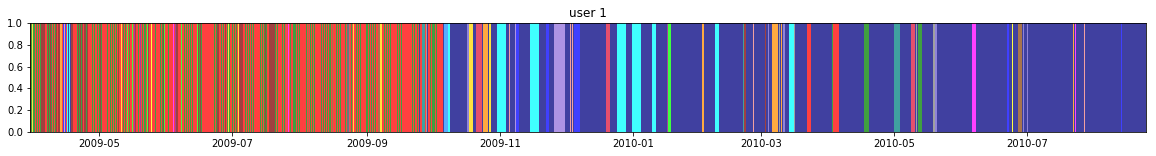

In [75]:
user = 1

ax = cstdf.plot_diary(user)

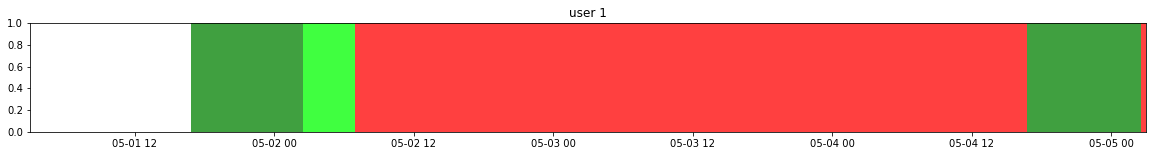

In [76]:
user = 1

start_datetime = pd.to_datetime('2009-05-1 030000')
end_datetime = pd.to_datetime('2009-05-5 030000')

ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

Plot diary onto map

In [77]:
# start_datetime = pd.to_datetime('2009-05-1 030000')
# end_datetime = pd.to_datetime('2009-05-21 030000')

selection = (ctdf['uid'] == user) & (start_datetime <= ctdf['datetime']) & ( ctdf['datetime']  <= end_datetime)
map_f = ctdf[selection].plot_trajectory(max_points=1000, hex_color='#000000')

selection = (stdf['uid'] == user) & (start_datetime <= stdf['datetime']) & ( stdf['datetime']  <= end_datetime)
map_f = cstdf[selection].plot_stops(popup=True , map_f=map_f)

map_f

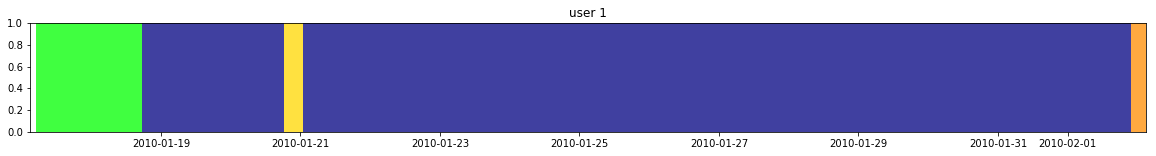

In [78]:
user = 1

start_datetime = pd.to_datetime('2010-01-17 030000')
end_datetime = pd.to_datetime('2010-02-2 030000')

ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

Plot diary onto map

In [79]:
# start_datetime = pd.to_datetime('2009-05-1 030000')
# end_datetime = pd.to_datetime('2009-05-21 030000')

selection = (ctdf['uid'] == user) & (start_datetime <= ctdf['datetime']) & ( ctdf['datetime']  <= end_datetime)
map_f = ctdf[selection].plot_trajectory(max_points=1000, hex_color='#000000')

selection = (stdf['uid'] == user) & (start_datetime <= stdf['datetime']) & ( stdf['datetime']  <= end_datetime)
map_f = cstdf[selection].plot_stops(popup=True , map_f=map_f)

map_f